In [1]:
from joblib import load
import numpy as np

In [2]:
yscaler = load("yscaler.joblib")

In [3]:
yscaler

MinMaxScaler(feature_range=(-1, 1))

In [4]:
model = load("single_layer.model")

In [5]:
def full_model(x):
    y = model.predict(x.reshape(1,-1))
    return yscaler.inverse_transform(y).flatten()

In [6]:
def auxiliary(y0, x):
    y = full_model(x)
    return np.sum((y-y0)**2)*100

Auxiliary: dado un punto en el espacio y0 y una combinación de motores x, predice el punto al que corresponde x, llamado y y luego calcula una función de coste parabólica con el mínimo en y0.

In [7]:
x0 = np.array([ 800.,    0.,  800.,    0., -800.,    0.,    0.,  800.])

In [8]:
y0 = full_model(x0)

In [9]:
y0

array([-0.02060116, -0.00906787])

In [10]:
def get_uniform_y(y0, stop, step, index=1):
    start = y0[index]
    sign = 1 if start<stop else -1
    out = [y0.copy()]
    y_new = y0.copy()
    while start*sign < stop*sign:
        start += sign*step
        y_new[index] = start
        out.append(y_new.copy())
    return np.array(out)

In [11]:
get_uniform_y(y0, stop=-0.02, step=0.002, index=1)

array([[-0.02060116, -0.00906787],
       [-0.02060116, -0.01106787],
       [-0.02060116, -0.01306787],
       [-0.02060116, -0.01506787],
       [-0.02060116, -0.01706787],
       [-0.02060116, -0.01906787],
       [-0.02060116, -0.02106787]])

In [12]:
from scipy.optimize import minimize
from functools import partial

In [13]:
def find_x(x0, y):
    res = minimize(partial(auxiliary, y), x0.copy(), method="l-bfgs-b")
    if res["success"]:
        return res["x"]
    else:
        return None

find x minimiza la parábola auxiliary para encontrar motores que hayan variado suavemente desde el punto anterior.

In [14]:
def compute_grid_1D(x0, ys):
    xs =[]
    for y in ys:
        x = find_x(x0,y)
        xs.append(x)
        if x is not None:
            x0=x.copy()
    return np.array(xs)

La función sobre esta linea genera una fila de puntos empezando por el central.

In [15]:
y_minus = get_uniform_y(y0, stop=-0.02, step=0.0012, index=1)
x_minus = compute_grid_1D(x0, y_minus[1:])
y_plus = get_uniform_y(y0, stop=0.02, step=0.0012, index=1)
x_plus = compute_grid_1D(x0, y_plus[1:])

In [16]:
y = np.vstack([y_minus[1:], y0, y_plus[1:]])
x = np.vstack([x_minus, x0, x_plus])

In [17]:
def compute_grid_2D(x0s, y0s, N):
    xs = []
    ys = []
    for x0,y0 in zip(x0s,y0s):
        y = np.array([y0 + e*np.array([1,0]) for e in np.linspace(0, 0.0226*2, N)])
        x = np.vstack([x0, compute_grid_1D(x0, y[1:])])
        xs.append(x)
        ys.append(y)
    return np.vstack(xs), np.vstack(ys)

La función sobre esta línea genera una cuadrícula dada la primera fila, usa cada elemento para generar suavemente su columna

In [18]:
x.shape, y.shape

((36, 8), (36, 2))

In [19]:
x_2d, y_2d = compute_grid_2D(x,y, x.shape[0])

In [20]:
import joblib

In [21]:
joblib.dump(x_2d, "motores_simulados.joblib")

['motores_simulados.joblib']

In [22]:
joblib.dump(y_2d, "posiciones_simuladas.joblib")

['posiciones_simuladas.joblib']

In [23]:
x_2d.shape

(1296, 8)

In [24]:
y_2d

array([[-0.02060116, -0.01026787],
       [-0.01930973, -0.01026787],
       [-0.01801831, -0.01026787],
       ...,
       [ 0.02201598,  0.02093213],
       [ 0.02330741,  0.02093213],
       [ 0.02459884,  0.02093213]])

In [25]:
#Tiene un paso como de 1mm.Con eso me salen 1500 puntos.
np.abs(y_2d[0,0]-y_2d[1,0])

0.0012914285714285718

In [26]:
import matplotlib.pyplot as plt

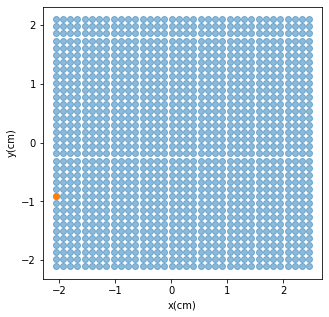

In [27]:
fig, ax = plt.subplots((1), figsize=(5,5))
plt.scatter(100*y_2d[:,0], 100*y_2d[:,1], alpha=0.5)
plt.scatter(100*y0[0], 100*y0[1])
plt.xlabel("x(cm)")
plt.ylabel("y(cm)");
plt.savefig("mesh.png")

In [28]:
y_2d.shape[0] // y.shape[0], y.shape[0]

(36, 36)

In [29]:
np.savetxt("posiciones_simuladas.txt", y_2d)
np.savetxt("motores_simulados.txt", x_2d)